In [333]:
import os
import pandas as pd
import matplotlib.pyplot as plt

df_list = []
filename_list = []
for filename in os.listdir("/home/frankwoods/Desktop/lassie/data/processed_data"):
    df = pd.read_csv(f"/home/frankwoods/Desktop/lassie/data/processed_data/{filename}")
    filename_list.append(filename)
    df_list.append(df)
print(filename_list)

['resistance_depth_15.csv', 'resistance_depth_36.csv', 'resistance_depth_50.csv', 'resistance_depth_54.csv', 'resistance_depth_25.csv', 'resistance_depth_69.csv', 'resistance_depth_67.csv', 'resistance_depth_46.csv', 'resistance_depth_1.csv', 'resistance_depth_49.csv', 'resistance_depth_45.csv', 'resistance_depth_4.csv', 'resistance_depth_44.csv', 'resistance_depth_59.csv', 'resistance_depth_64.csv', 'resistance_depth_0.csv', 'resistance_depth_21.csv', 'resistance_depth_71.csv', 'resistance_depth_53.csv', 'resistance_depth_20.csv', 'resistance_depth_75.csv', 'resistance_depth_43.csv', 'resistance_depth_61.csv', 'resistance_depth_40.csv', 'resistance_depth_24.csv', 'resistance_depth_62.csv', 'resistance_depth_65.csv', 'resistance_depth_47.csv', 'resistance_depth_41.csv', 'resistance_depth_13.csv', 'resistance_depth_51.csv', 'resistance_depth_5.csv', 'resistance_depth_2.csv', 'resistance_depth_26.csv', 'resistance_depth_38.csv', 'resistance_depth_63.csv', 'resistance_depth_9.csv', 'resis

In [334]:

def extract_features(df):
    res = df["resistance"]
    dep = df["depth"]
    return pd.DataFrame([{
        "res_mean": res.mean(),
        "res_max": res.max(),
        "slope": res.max() / dep.max(),
        "depth_max": dep.max(),
        # "skew": res.skew(), # measure of right or left skew
        # "kurtosis": res.kurtosis(), # measure of tailness
    }])

# shape (n,m) where n is number of df and m is extracted feaetures
representation_list = []
for df in df_list:
    representation_list.append(extract_features(df))
print(f"example: {representation_list[0]}")


example:     res_mean    res_max        slope  depth_max
0  21.169391  36.954578  8994.395778   0.004109


# Visualize Extracted Features

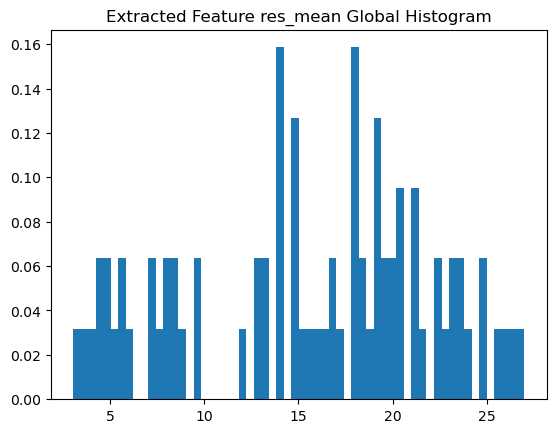

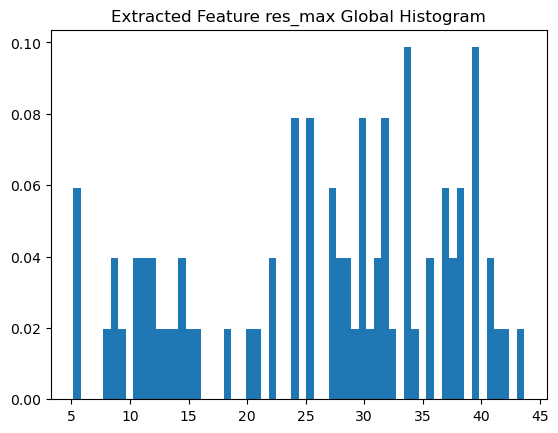

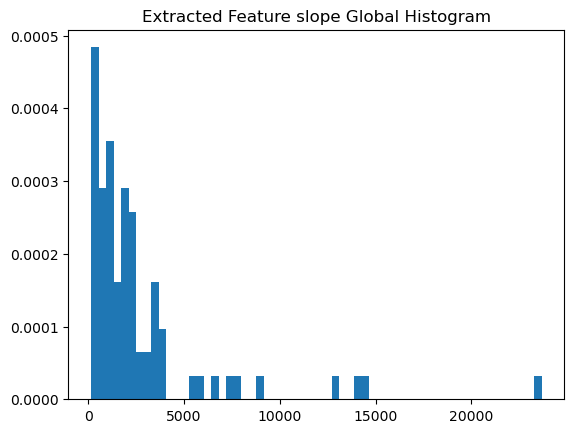

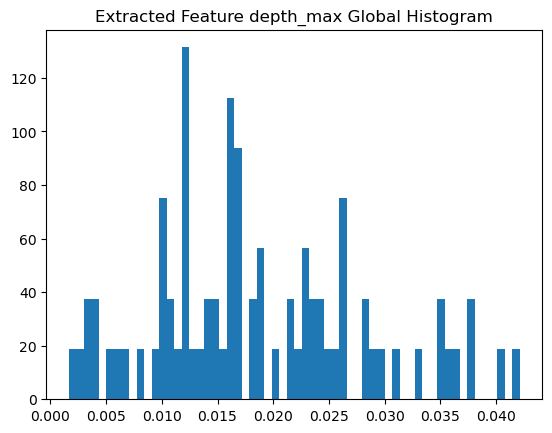

In [335]:
representation_df  = pd.concat(representation_list, axis=0, ignore_index=True)
# print(representation_df)
for col in representation_df.columns:
    plt.hist(representation_df[col], bins=60, density=True)
    plt.title(f"Extracted Feature {col} Global Histogram")
    plt.show()


# Scale Features

In [336]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def transform_features(df):
    df = df.copy()  # avoid modifying original
    # Apply cube root to 'slope'
    if "slope" in df.columns: df['slope'] = np.log(df['slope'])
    # if "skew" in df.columns: df["skew"] = df["skew"] ** 1.1
    # if "kurtosis" in df.columns: df["kurtosis"] = np.sqrt(df["kurtosis"]) 
    # Standardize
    scaler = StandardScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])
    return df

scaled_representations = transform_features(representation_df)

# for col in scaled_representations.columns:
#     plt.hist(scaled_representations[col], bins=60, density=True)
#     plt.title(f"Scaled Extracted Feature {col} Global Histogram")
#     plt.show()


## K-Means Clustering Implementation w/ k-means++ init for centroids

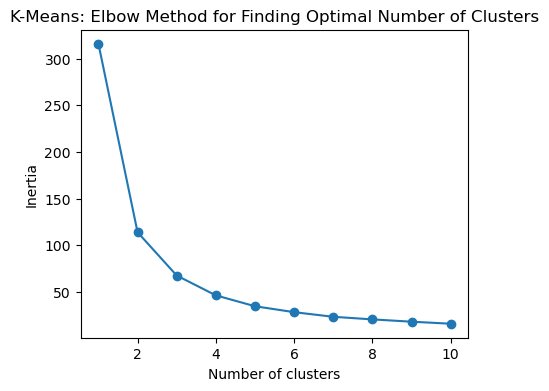

In [337]:
from sklearn.cluster import KMeans
import numpy as np

inertias = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=100).fit(scaled_representations)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(5,4))
plt.plot(range(1,11), inertias, marker='o')
plt.title("K-Means: Elbow Method for Finding Optimal Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid=True
plt.show()

# print(kmeans.labels_)

# kmeans.predict # for predicting which cluster a data point belongs too

# Visualization Functions

In [338]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_clusters(representation_list, y_labels, graph_title="", use_pca=False, use_sne=False, two_d=False, overlay_plot=False):
    if use_pca:
        pca = PCA(n_components=2) # reduce data down to 2 dims
        X_pca = pca.fit_transform(representation_list) # learns directions of max vairance, projects onto 2D
        # print(y_labels)
        plt.title(f"{graph_title} Clustering Visualized with pca")
        # x_pca: x_dim, x_pca: y_dim, c: color points based on clusters, cmap: color map
        # X_pca[:,0] -> 0th index of every row, X_pca[:,1] -> 1st index of every row
        label_color_map = {
            0: 'red',
            1: 'grey',
            2: 'blue',
            3: "green",
            4: "purple",
        }
        colors = [label_color_map[label] for label in y_labels]
        plt.scatter(X_pca[:,0], X_pca[:,1], c=colors)
        # plt.scatter(X_pca[:,0], X_pca[:,1], c=y_labels, cmap='coolwarm')
        plt.show()
    if overlay_plot:
        plt.figure(figsize=(8,6))
        a = 0.3
        for i in range(len(y_labels)):
            y = y_labels[i]
            df = df_list[i]
            if y == 0:
                plt.plot(df["depth"], df["resistance"], color="red", alpha=a)
            elif y == 1:
                plt.plot(df["depth"], df["resistance"], color="grey", alpha=a)
            elif y == 2:
                plt.plot(df["depth"], df["resistance"], color="blue", alpha=a)
            elif y == 3:
                plt.plot(df["depth"], df["resistance"], color="green", alpha=a)
            elif y == 4:
                plt.plot(df["depth"], df["resistance"], color="purple", alpha=a)
        plt.xlabel('Depth')
        plt.ylabel('Resistance')
        plt.title('Depth vs Resistance Curves')
        plt.show()

    if len(representation_list.columns) == 2 and two_d:
        x = representation_list.columns[0]
        y = representation_list.columns[1]
        plt.scatter(representation_list[x], representation_list[y], c=y_labels, cmap="coolwarm")
        plt.title(f"{graph_title} Clustering: {x} and {y}")
        plt.xlabel(x)
        plt.ylabel(y)
        plt.show()


def display_curve(df_list, graph_i):
    plt.figure(figsize=(8,5))       
    plt.plot(df_list[graph_i]['depth'], df_list[graph_i]['resistance'], marker='o', linestyle='-')
    plt.xlabel('Depth')
    plt.ylabel('Resistance')
    plt.title('Resistance vs Depth')
    plt.show()

# display max 2 graphs per label
def visualize_cluster_curves(df_list, y_labels, max_num_graphs_per_cluster=2):
    # Index list
    df_list_i = list(range(len(df_list)))

    # Sort y_labels and indices together
    y_labels_sorted, df_list_sorted = zip(*sorted(zip(y_labels, df_list_i)))
    y_labels_sorted = list(y_labels_sorted)
    df_list_sorted = list(df_list_sorted)

    displayed_count = {}  # Track how many times we've displayed each label

    for i in range(len(y_labels_sorted)):
        label = y_labels_sorted[i]
        index = df_list_sorted[i]

        # Display at most 2 curves per label
        if displayed_count.get(label, 0) < max_num_graphs_per_cluster:
            print(f"y_label: {label}")
            display_curve(df_list, index)
            displayed_count[label] = displayed_count.get(label, 0) + 1


# K-Means Clustering
- assumes
    - spherical clusters (isotropic)
    - similar size clusters (equal variance)
    - features are on same scale
    - clusters are linearly separable
    - number of clusters (k) is known

kmeans labels:
[3 2 3 2 2 2 1 2 1 1 0 1 1 2 0 1 1 0 1 3 1 0 2 1 3 3 1 0 3 0 0 0 3 1 2 2 1
 3 1 2 2 3 0 2 1 0 1 1 0 2 1 2 0 0 3 3 2 3 2 2 1 2 1 3 2 1 1 1 3 3 0 3 3 1
 3 1 2 0 1]


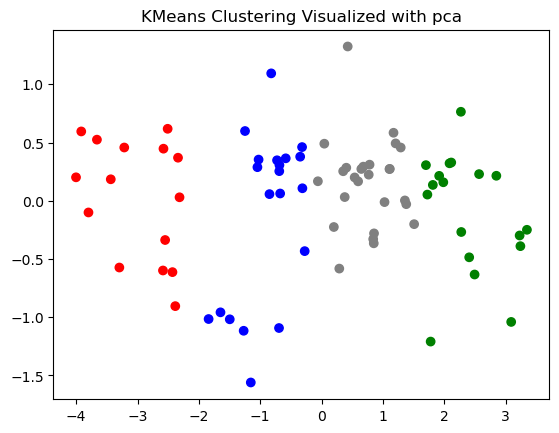

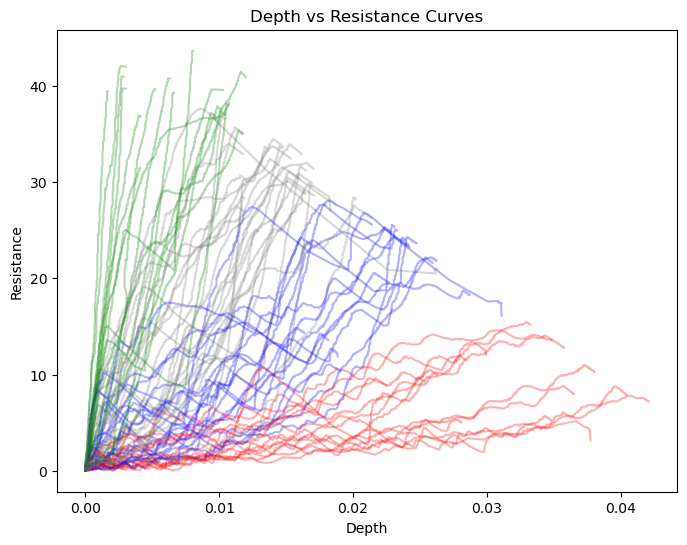

In [339]:
kmeans_elbow = 4
kmeans = KMeans(n_clusters=kmeans_elbow, init="k-means++", n_init=100).fit(scaled_representations)
print(f"kmeans labels:\n{kmeans.labels_}")
visualize_clusters(scaled_representations, kmeans.labels_, graph_title="KMeans", use_pca=True, use_sne=False, two_d=False, overlay_plot=True)
# visualize_cluster_curves(df_list, kmeans.labels_, max_num_graphs_per_cluster=2)

# Plotting a single graph for each cluster

In [340]:

# def plot(df_list, graph_i):
#     plt.figure(figsize=(8,5))         # Optional: set figure size    
#     plt.plot(df_list[graph_i]['depth'], df_list[graph_i]['resistance'], marker='o', linestyle='-')
#     plt.xlabel('Depth')
#     plt.ylabel('Resistance')
#     plt.title('Resistance vs Depth')
#     concat_df_list = pd.concat(df_list, axis=0, ignore_index=True)
#     plt.xlim(0, concat_df_list["depth"].max())
#     plt.ylim(0, concat_df_list["resistance"].max())
#     # plt.grid(True)                    
#     plt.show()

# print("0:")
# plot(df_list, 1)
# print("1:")
# plot(df_list, 10)
# print("2:")
# plot(df_list, 0)

# d = {}
# print(len(filename_list) == len(df_list))
# for i in range(len(filename_list)):
#     d[filename_list[i]] = kmeans.labels_[i]
# for key, value in d:
    

# DBSCAN
- assumes
    - clusters are dense regions seperated by low-density areas
    - two parameters define density (eps, min_samples)
    - Does not require number of clusters (k)
    - Clusters may vary in shape and size

In [341]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=4).fit(scaled_representations)
print(dbscan.labels_)
# visualize_clusters(scaled_representations, dbscan.labels_, graph_title="DBSCAN", use_pca=True, use_sne=False, two_d=True)

[-1  4 -1  0  0  0  0 -1 -1 -1  1  0  0  0  1  0  0  2  0  0  0  3 -1  0
 -1  0  0  3  0  2  2  1 -1  0  0  0  0  0  0  0 -1 -1  2  0  0 -1  0  0
  2  4  0  0  1  3 -1 -1  0  0  0  4  0 -1  0 -1  0  0  0  0  0  0 -1  0
 -1  0 -1  0  4 -1  0]


# Hierarchical Clustering

[0 4 0 1 1 1 3 1 3 1 2 3 3 1 2 3 3 2 1 0 3 2 4 1 0 0 3 2 0 2 2 2 0 3 1 1 3
 0 3 1 4 0 2 1 1 2 3 3 2 4 3 1 2 2 0 0 1 0 1 4 3 1 3 0 1 3 3 3 0 0 2 0 0 3
 0 3 4 2 3]


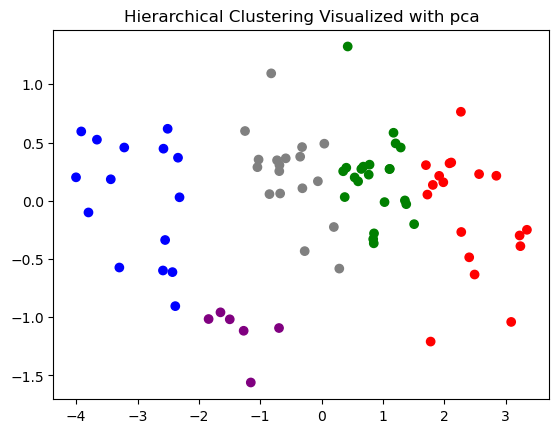

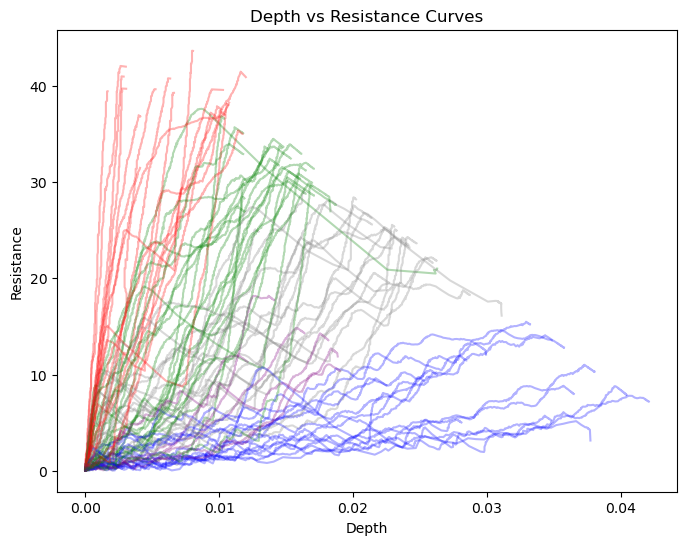

In [342]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# if distance_threshold != None then n_clusters = None
hierarchical = AgglomerativeClustering(distance_threshold=None, n_clusters=5)
hierarchical.fit(scaled_representations)
linkage = "Ward"
print(hierarchical.labels_)
visualize_clusters(scaled_representations, hierarchical.labels_, graph_title="Hierarchical", use_pca=True, overlay_plot=True)

# plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
# plot_dendrogram(hierarchical, truncate_mode="level", p=5)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

In [343]:
# plot(df_list, 0)
# plot(df_list, 3)
# plot(df_list, 10)
# plot(df_list, 6)
# plot(df_list, 1)
